In [71]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import scipy.optimize as opt
import scipy.fft
from scipy.special import factorial
import math
# import csv
from matplotlib import rc, rcParams

def fitlin(x, y, sig):
    '''
    Performs a least-squares linear fit

    Parameters
    ----------
    x : array
        The independent data
    y : array
        The dependent data
    sig : array
        The uncertainty in y

    Returns
    ----------
    popt : array
        Optimal values for the parameters
    perr : array
        The uncertainty on the fit parameters
    chisq : float
        The value of chi-squared
    yfit : array
        The values of the fitted line at each x
    '''

    ### See Bevington and Robinson Ch. 6 (p. 114)

    # TLDR: by minimizing the chi-squared, you get a system of equations
    ###         term3 = b * term1 + m * term5
    ###         term4 = b * term5 + m * term2
    ###     this equation can be solved by taking determinants
    ###     the inverse of the matrix (the curvature matrix of a linear ftn)
    ###         ( term1 term5 )
    ###         ( term5 term2 )
    ###     is the covariance matrix, and the diagonal terms are the fit errors
    ###     the full formulas can be found on page 114 of Bevington

    term1 = np.sum(    1 / sig**2 )
    term2 = np.sum( x**2 / sig**2 )
    term3 = np.sum(    y / sig**2 )
    term4 = np.sum(  x*y / sig**2 )
    term5 = np.sum(    x / sig**2 )

    delta = term1*term2 - term5**2

    b = ( term2*term3 - term5*term4 ) / delta
    m = ( term1*term4 - term5*term3 ) / delta
    popt = np.array([b, m])

    berr = np.sqrt( term2 / delta )
    merr = np.sqrt( term1 / delta )
    perr = np.array([berr, merr])

    yfit = b + m*x

    chisq = np.sum( ( (y - yfit) / sig )**2 )

    return popt, perr, chisq, yfit

In [ ]:
floating_brownian_stem = 'data/Real/'
floating_brownian_suffix = 'mA_20k_10s_3u_10-29' # has _2 or just .txt
laser_powers = [100.6, 193.2, 293.2, 392.6, 493.1]
laser_power_strs = [str(power).split(".") for power in laser_powers]
dirs = ['_'.join(tup) for tup in laser_power_strs]
file_starts = ['-'.join(tup) for tup in laser_power_strs]
floating_brownian_files = [floating_brownian_stem + dirs[i] + '/' + file_starts[i] + floating_brownian_suffix for i in range(len(laser_powers))]
floating_brownian_files = [(floating_brownian_files[0] + ".txt",)] + [(file_name + ".txt", file_name + "_2.txt") for file_name in floating_brownian_files[1:]]
for i in floating_brownian_files:
    print(i)

In [73]:
data = []
for power_tuple in floating_brownian_files:
    power_data = []
    for trial_file in power_tuple:
        with open(trial_file, mode ='r') as file:
            lines = file.readlines()
            power_data += [[[float(i) for i in line.split("\t")] for line in lines]]

    data += [np.array(power_data)]

0.06547369814849414 0.26771495720499383
[-17.05499848] [[0.00926221]]
[ 3.4253589  -3.27006916] [[ 0.15690778 -0.02121651]
 [-0.02121651  0.00288097]]


c:\Users\alexa\Documents\GitHub\jlab\Optical-Trap-master\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:654: ComplexWarning: Casting complex values to real discards the imaginary part
  a = asarray(a, dtype=dtype, order=order)


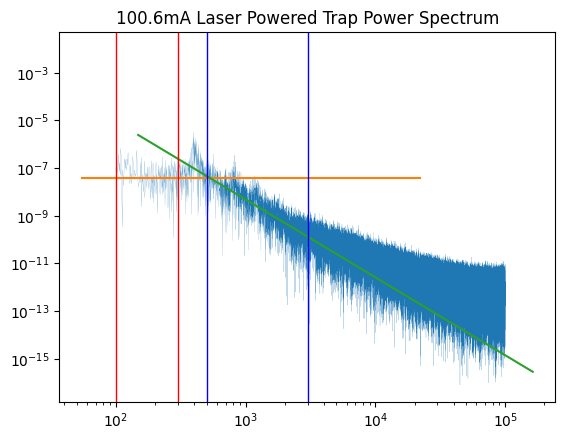

0.18250516159500954 0.16594918080500756
[-17.38985509] [[0.00432952]]
[ 9.20963033 -3.92109174] [[ 0.60366356 -0.07922191]
 [-0.07922191  0.01041195]]


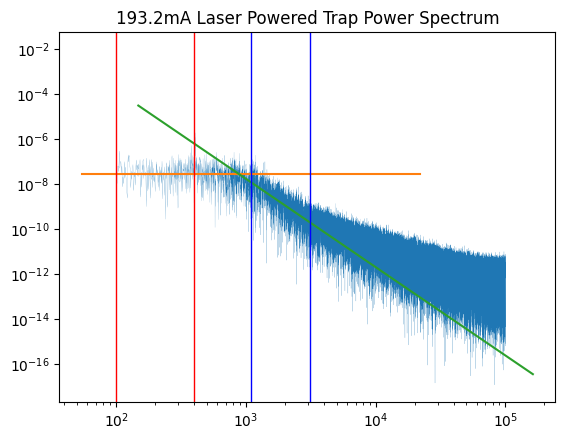

0.18397481681301128 0.1652781797100045
[-17.27960325] [[0.00640429]]
[11.49230174 -4.19791259] [[ 0.60757949 -0.07973581]
 [-0.07973581  0.01047949]]


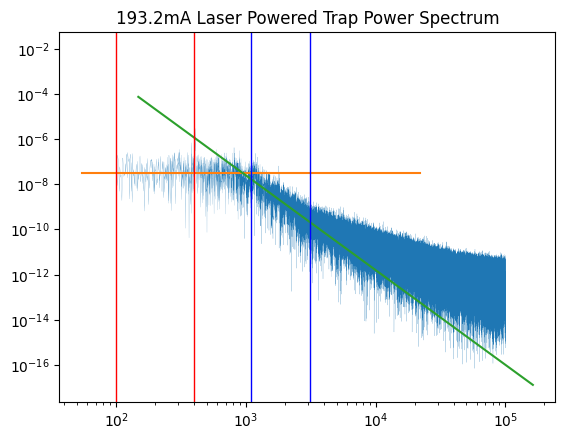

0.3285651867505393 0.34814013677500844
[-16.09779068] [[0.00436894]]
[12.92132092 -4.11325987] [[ 0.71364948 -0.09305463]
 [-0.09305463  0.01214946]]


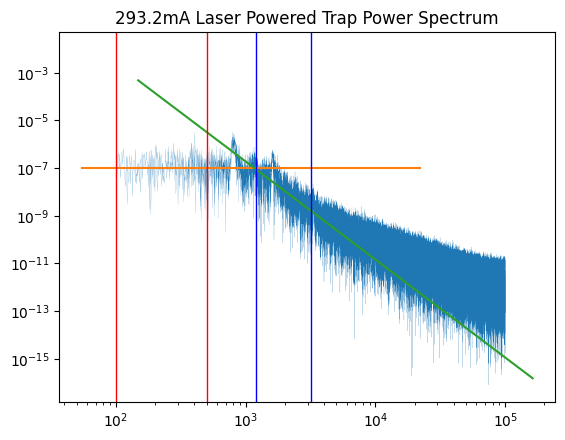

0.33075684455500104 0.3230002390299779
[-16.37628412] [[0.00377439]]
[10.02028928 -3.81167868] [[ 0.61250221 -0.07986577]
 [-0.07986577  0.01042749]]


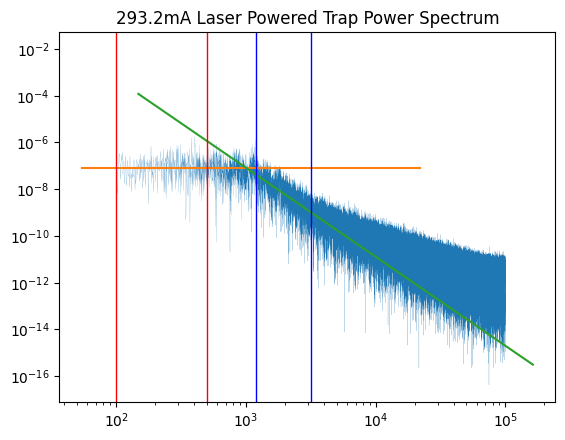

0.47977419052500325 0.5188163631200163
[-15.72017102] [[0.00397833]]
[12.27245961 -3.9617267 ] [[ 0.69996473 -0.09071658]
 [-0.09071658  0.01177074]]


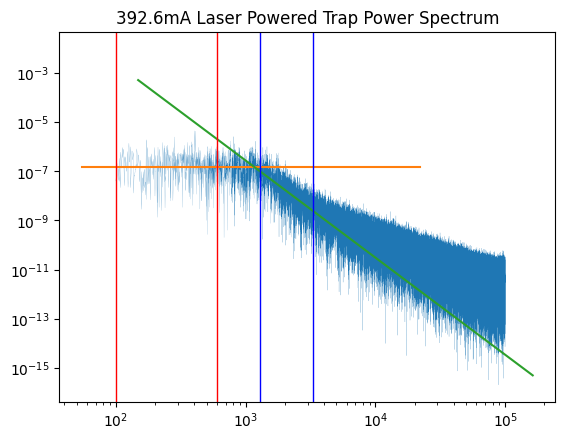

0.46343767259500035 0.515296755840005
[-15.62646085] [[0.00392527]]
[12.93907957 -4.04113893] [[ 0.67940927 -0.08805256]
 [-0.08805256  0.01142507]]


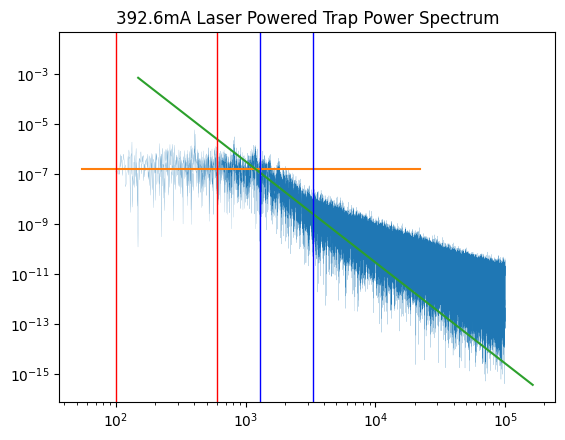

0.6076066497470983 0.5415833099449956
[-15.69071377] [[0.00288122]]
[16.12675389 -4.48139888] [[ 0.76890411 -0.09907837]
 [-0.09907837  0.01278031]]


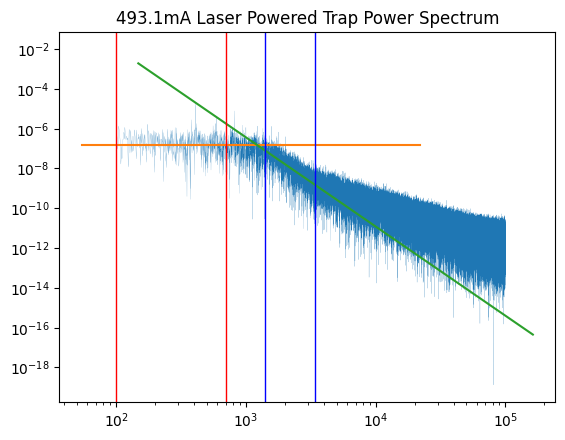

0.593918984680013 0.5906270542950246
[-15.56940686] [[0.00248817]]
[13.77307709 -4.13646108] [[ 0.78666821 -0.10136739]
 [-0.10136739  0.01307558]]


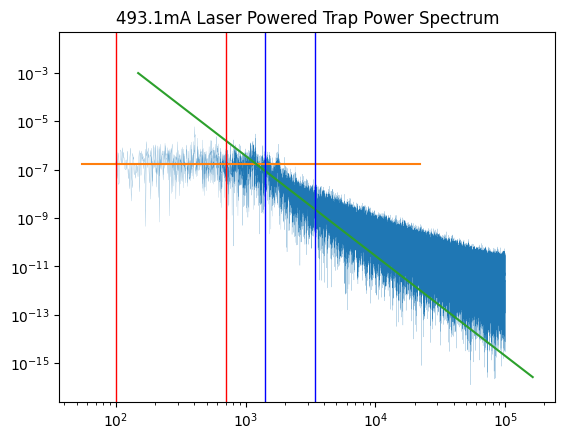

In [74]:
fits = []
for i, power_tuple in enumerate(data):
    trial_fits = []
    for trial_data in power_tuple:
        # plt.plot(trial_data[:,0], trial_data[:,1], lw=0.1)
        # plt.show()
        avgx = sum(trial_data[:,0] / len(trial_data))
        avgy = sum(trial_data[:,1] / len(trial_data))
        print(avgx, avgy)

        dists = np.sqrt((trial_data[:,0] - avgx) ** 2 + (trial_data[:,1] - avgy) ** 2)
        freqs = (scipy.fft.fft(dists) / len(dists))**2
        plt.loglog(range(len(freqs))[100:10**5], abs(freqs[100:10**5]), lw=0.1)

        def constant_fit(x, c):
            return c 
        def neg1_slope_fit(x, c, m):
            return m*np.array(x) + c 
        constrange = [100, 3*100 + i*100]
        neg1range = [1000 + i*100  if i> 0 else 500, 3*10**3 + i*100]
        constopt, constcov = opt.curve_fit(constant_fit, np.log(range(len(freqs))[constrange[0]:constrange[1]]), np.log(freqs[constrange[0]:constrange[1]]), p0=(1))
        neg1opt, neg1cov = opt.curve_fit(neg1_slope_fit, np.log(range(len(freqs))[neg1range[0]:neg1range[1]]), np.log(freqs[neg1range[0]:neg1range[1]]), p0=(1, -1))
        print(constopt, constcov)
        print(neg1opt, neg1cov)
        plottingconst = np.linspace(4, 10, 100)
        plottingneg1 = np.linspace(5, 12, 100)
        plt.loglog(np.e ** plottingconst, np.e ** np.array([constopt[0]] * 100))
        plt.loglog(np.e ** plottingneg1, np.e ** (neg1opt[1] * plottingneg1 + np.array([neg1opt[0]] * 100)))
        plt.axline((constrange[0], 1e-8), (constrange[0], 1e-2), linewidth=1, color='r')
        plt.axline((constrange[1], 1e-8), (constrange[1], 1e-2), linewidth=1, color='r')
        plt.axline((neg1range[0], 1e-8), (neg1range[0], 1e-2), linewidth=1, color='b')
        plt.axline((neg1range[1], 1e-8), (neg1range[1], 1e-2), linewidth=1, color='b')
        plt.title(str(laser_powers[i])+'mA Laser Powered Trap Power Spectrum')
        plt.show()

        trial_fits += [{'c':(constopt, constcov), 'bm':(neg1opt, neg1cov)}]
    fits += [trial_fits]

    

In [75]:
# print(fits)
f0init = []
f0initerr = []
for power in fits:
    for trial in power:
        # we want f0 * m + b = c => f0 = (c-b)/m
        subtraction = (trial['c'][0] - trial['bm'][0][0])
        division = trial['bm'][0][1]
        f0beforee = subtraction / division # this is alpha/(2*pi*beta)
        f0 = np.e ** f0beforee
        # need: beta!
        # err is (sq of err before exponentiation) * (sq of derivative of exponent which is just... the exponent)
        f0err = np.sqrt((trial['c'][1] ** 2 + trial['bm'][1][0,0] ** 2) / (subtraction ** 2) + trial['bm'][1][1,1] ** 2 / (division ** 2)) * f0
        f0init += [f0[0]]
        f0initerr += [f0err[0][0]]

print(f0init)
print('wwwwwwww')
f0s = []
f0errs = []
for power in fits[1:]:  # Skip first row
    for trial in power:
        subtraction = (trial['c'][0] - trial['bm'][0][0])
        division = trial['bm'][0][1]
        f0beforee = subtraction / division
        f0 = np.e ** f0beforee
        f0err = np.sqrt((trial['c'][1] ** 2 + trial['bm'][1][0,0] ** 2) / (subtraction ** 2) + trial['bm'][1][1,1] ** 2 / (division ** 2)) * f0
        f0s.append(f0[0])
        f0errs.append(f0err[0][0])

print("f0s:", f0s)
print("f0errs:", f0errs)

# Combine pairs of measurements with their errors to get weighted means and variances
combined_f0s = [f0s[0]]
combined_f0_errs = [f0errs[0]]

for i in range(0, len(f0s), 2):
    if i+1 < len(f0s):  # Ensure we have a pair
        # Weights are inverse of variances
        w1 = 1/(f0errs[i]**2)
        w2 = 1/(f0errs[i+1]**2)
        
        # Weighted mean
        mean = (w1*f0s[i] + w2*f0s[i+1])/(w1 + w2)
        
        # Standard error of weighted mean
        err = np.sqrt(1/(w1 + w2))
        
        combined_f0s.append(mean)
        combined_f0_errs.append(err)

print("Combined f0s:", combined_f0s)
print("Combined f0 errors:", combined_f0_errs)



[np.float64(524.7771866509016), np.float64(883.3254719188391), np.float64(947.5312836735084), np.float64(1158.6552766112898), np.float64(1017.5807327929409), np.float64(1171.1778115541001), np.float64(1174.603080863851), np.float64(1211.8414860994237), np.float64(1204.259596990797)]
wwwwwwww
f0s: [np.float64(883.3254719188391), np.float64(947.5312836735084), np.float64(1158.6552766112898), np.float64(1017.5807327929409), np.float64(1171.1778115541001), np.float64(1174.603080863851), np.float64(1211.8414860994237), np.float64(1204.259596990797)]
f0errs: [np.float64(20.18394723651785), np.float64(20.14955279998233), np.float64(28.699428705411673), np.float64(23.775771396273754), np.float64(29.492150664006562), np.float64(28.13416657747339), np.float64(29.488904100042006), np.float64(32.50984914261152)]
Combined f0s: [np.float64(524.7771866509016), np.float64(883.3254719188391), np.float64(915.4831293329794), np.float64(1074.9967403962746), np.float64(1172.9711190646399), np.float64(1208.

In [99]:
import pandas as pd
# dynamic viscosity at 23°C
eta_23C = 9.32e-4  # Pa·s

# drag coefficient
gamma_23C = 3 * np.pi * eta_23C * 3.21*10**(-6)  # N·s/m
gamma_23C_conversion = gamma_23C * 10**6  # Convert from N·s/m to pN·s/μm (10^6 = 10^3 μm/m * 10^3 pN/N)
# Convert to pN/μm/s: multiply by 10^12 (N->pN and m->μm)
gamma_23C_N_m = 0.028 * 10**(0)  # Convert from pN·s/μm to N·s/m (10^-12 = 10^-3 m/μm * 10^-9 N/pN)
print(f"gamma = {gamma_23C} N·s/m")
print(f"gamma = {gamma_23C_N_m} pN·s/μm")

# Recalculate trap stiffness for the given frequencies
data_updated = {
    "Corner Frequency (Hz)": combined_f0s,
    "Trap Stiffness (k) (N/m)": [2 * np.pi * f * gamma_23C for f in combined_f0s]
}

# Convert to DataFrame for display
df_updated = pd.DataFrame(data_updated)

print(df_updated.to_string())
# Error propagation for trap stiffness k = 2π * f * γ
# For γ = 3πηd where η is viscosity and d is diameter

# Estimate uncertainties in base values
d = 3.21e-6  # m
d_err = 0.01e-6  # Uncertainty in last sig fig
eta = 9.32e-4  # Pa·s 
eta_err = 0.01e-4  # Estimate uncertainty in last sig fig

# Calculate gamma uncertainty using propagation of errors
# γ = 3πηd
# (Δγ/γ)^2 = (Δη/η)^2 + (Δd/d)^2
rel_gamma_err = np.sqrt((eta_err/eta)**2 + (d_err/d)**2)
gamma_err = gamma_23C * rel_gamma_err

# Calculate trap stiffness uncertainties
# k = 2πfγ
# (Δk/k)^2 = (Δf/f)^2 + (Δγ/γ)^2
k_vals = data_updated["Trap Stiffness (k) (N/m)"]
k_errs = []

for f, f_err in zip(combined_f0s, combined_f0_errs):
    rel_k_err = np.sqrt((f_err/f)**2 + rel_gamma_err**2)
    k = 2 * np.pi * f * gamma_23C
    k_err = k * rel_k_err
    k_errs.append(k_err)

# Add errors to dataframe and format based on uncertainties
data_with_errors = []
for f, f_err, k, k_err in zip(combined_f0s, combined_f0_errs, k_vals, k_errs):
    # Format k to 3 significant figures
    k_magnitude = int(np.floor(np.log10(abs(k))))
    k_rounded = np.round(k / 10**k_magnitude, 3) * 10**k_magnitude
    
    # Round error to same decimal place as k
    decimals = -int(np.floor(np.log10(k_err)))
    k_err_rounded = np.round(k_err, decimals)
    
    data_with_errors.append({
        "Corner Frequency (Hz)": f"{f:.1f}",
        "Trap Stiffness (k) (N/m)": f"{k_rounded:#.3g}",  # Use #.3g to preserve trailing zeros
        "Trap Stiffness Error (N/m)": f"{k_err_rounded:.{max(0, decimals)}e}"
    })

df_final = pd.DataFrame(data_with_errors)
print("\nUpdated results with appropriate significant figures:")
print(df_final.to_string())
# Report trap stiffness to 3 significant figures and error to 1 significant figure
data_with_errors = []
for f, f_err, k, k_err in zip(combined_f0s, combined_f0_errs, k_vals, k_errs):
    # Format k to 3 s.f.
    k_magnitude = int(np.floor(np.log10(abs(k))))
    k_rounded = np.round(k / 10**k_magnitude, 2) * 10**k_magnitude
    k_str = f"{k_rounded:.4g}"
    
    # Format error to 1 s.f.
    k_err_str = f"{k_err:.2g}"
    
    data_with_errors.append({
        "Corner Frequency (Hz)": f"{f:.1f}",
        "Trap Stiffness (k) (N/m)": k_str,
        "Trap Stiffness Error (N/m)": k_err_str
    })

df_final = pd.DataFrame(data_with_errors)
print("\nUpdated results with appropriate significant figures:")
print(df_final.to_string())





gamma = 2.8196296720792968e-08 N·s/m
gamma = 0.028 pN·s/μm
   Corner Frequency (Hz)  Trap Stiffness (k) (N/m)
0             524.777187                  0.000093
1             883.325472                  0.000156
2             915.483129                  0.000162
3            1074.996740                  0.000190
4            1172.971119                  0.000208
5            1208.419101                  0.000214

Updated results with appropriate significant figures:
  Corner Frequency (Hz) Trap Stiffness (k) (N/m) Trap Stiffness Error (N/m)
0                 524.8                 9.30e-05              8.0000000e-07
1                 883.3                 0.000157               4.000000e-06
2                 915.5                 0.000162               3.000000e-06
3                1075.0                 0.000190               3.000000e-06
4                1173.0                 0.000208               4.000000e-06
5                1208.4                 0.000214               4.000000e-

Loaded 5 power levels of floating bead data
Power level 100.6mA: 4 trials
[{'axis': 'x', 'qpd_x': array([ 0.0685582,  0.0682296,  0.0679011, ..., -0.0369035, -0.0375606,
       -0.0375606]), 'qpd_y': array([0.329748, 0.330734, 0.331063, ..., 0.132624, 0.133281, 0.132624]), 'strain_x': array([5.49151, 5.49184, 5.49249, ..., 5.49052, 5.49052, 5.49085]), 'strain_y': array([5.1094 , 5.1094 , 5.10908, ..., 5.10842, 5.10776, 5.10809])}, {'axis': 'x', 'qpd_x': array([0.0219054, 0.0225624, 0.0219054, ..., 0.0179629, 0.0173058,
       0.0179629]), 'qpd_y': array([0.17402 , 0.174348, 0.17402 , ..., 0.172706, 0.172377, 0.172377]), 'strain_x': array([2.49418, 2.49517, 2.4955 , ..., 2.4932 , 2.49287, 2.49353]), 'strain_y': array([5.10875, 5.10842, 5.10809, ..., 5.10875, 5.10842, 5.10743])}, {'axis': 'y', 'qpd_x': array([0.0120491 , 0.0120491 , 0.0123777 , ..., 0.0100779 , 0.00974933,
       0.00942079]), 'qpd_y': array([0.171392, 0.171063, 0.171392, ..., 0.173691, 0.174677, 0.175006]), 'strain_x': 

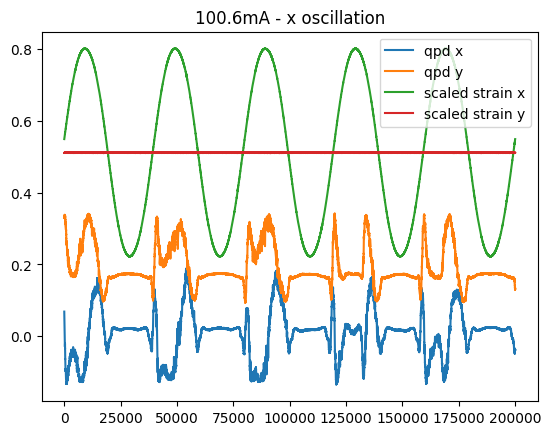

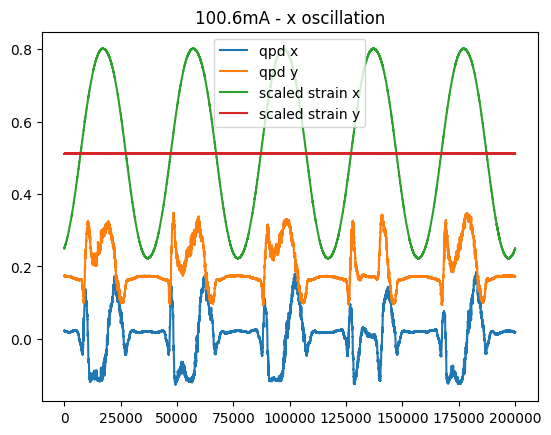

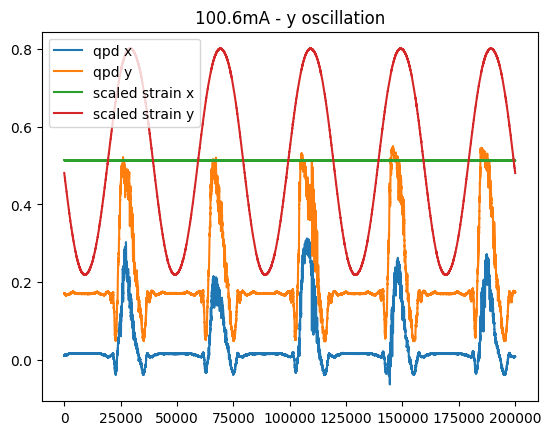

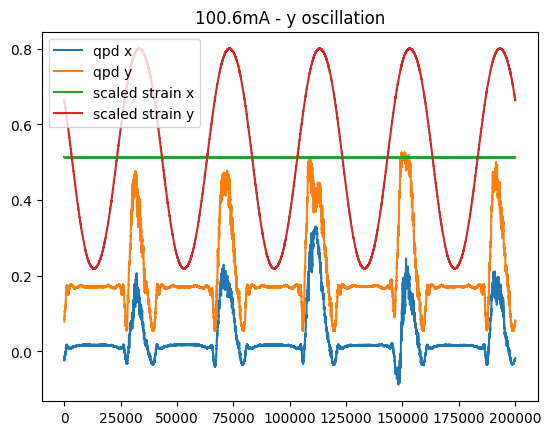

Power level 193.2mA: 4 trials
[{'axis': 'x', 'qpd_x': array([ 0.0583734,  0.0573878,  0.0554165, ..., -0.0428172, -0.0405175,
       -0.0401889]), 'qpd_y': array([0.177962, 0.176977, 0.178619, ..., 0.251884, 0.251884, 0.25287 ]), 'strain_x': array([7.20457, 7.20424, 7.20424, ..., 7.20424, 7.20457, 7.2049 ]), 'strain_y': array([5.10875, 5.10809, 5.10842, ..., 5.11105, 5.11039, 5.11006])}, {'axis': 'x', 'qpd_x': array([ 0.0889277,  0.0899134,  0.0902419, ..., -0.0263902, -0.0277044,
       -0.0296756]), 'qpd_y': array([0.141166, 0.140837, 0.141494, ..., 0.237757, 0.238085, 0.235786]), 'strain_x': array([3.74462, 3.74561, 3.74561, ..., 3.74561, 3.74594, 3.74659]), 'strain_y': array([5.10678, 5.10678, 5.10678, ..., 5.10842, 5.10875, 5.10842])}, {'axis': 'y', 'qpd_x': array([0.13788  , 0.140837 , 0.142151 , ..., 0.055088 , 0.0580449,
       0.0570593]), 'qpd_y': array([0.690815, 0.689173, 0.68753 , ..., 0.745353, 0.743053, 0.744368]), 'strain_x': array([5.13602, 5.13569, 5.13503, ..., 5.133

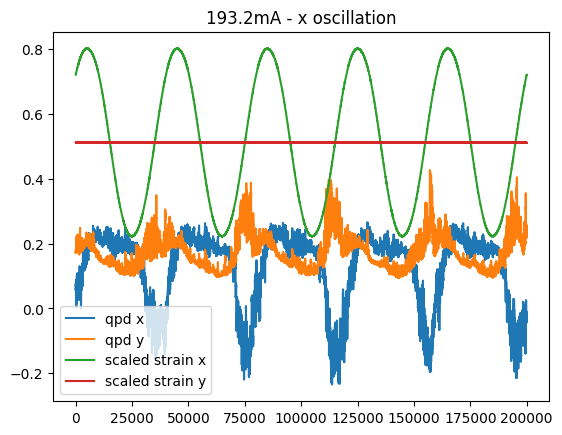

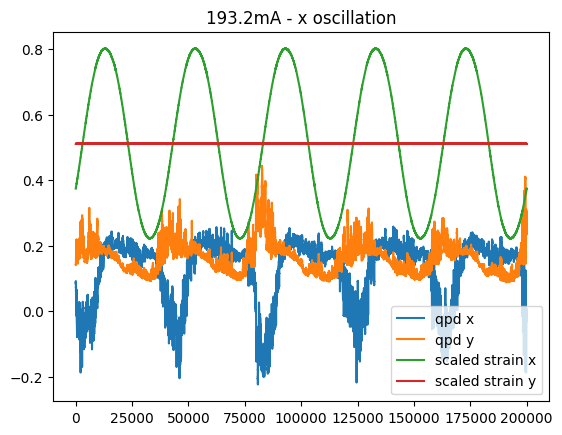

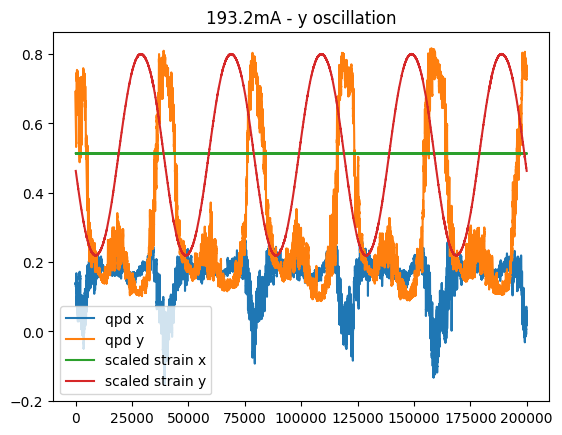

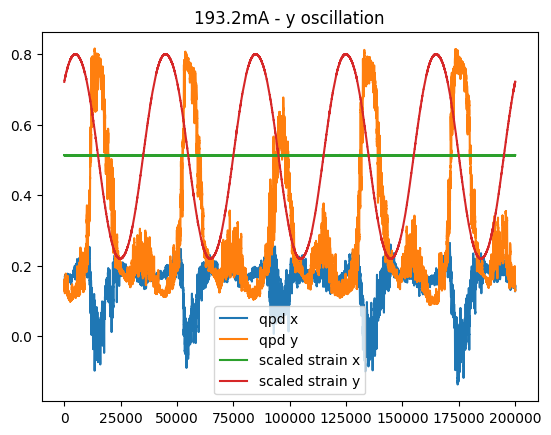

Power level 293.2mA: 4 trials
[{'axis': 'x', 'qpd_x': array([0.390529, 0.390857, 0.391843, ..., 0.372787, 0.373116, 0.372459]), 'qpd_y': array([0.295909, 0.29558 , 0.295252, ..., 0.312007, 0.312007, 0.312007]), 'strain_x': array([6.5593 , 6.55864, 6.55864, ..., 6.56455, 6.56357, 6.56324]), 'strain_y': array([5.10776, 5.10776, 5.10743, ..., 5.10776, 5.10743, 5.10809])}, {'axis': 'x', 'qpd_x': array([0.398414, 0.398085, 0.398085, ..., 0.400713, 0.399399, 0.399728]), 'qpd_y': array([0.388229, 0.3879  , 0.3879  , ..., 0.397428, 0.397428, 0.397428]), 'strain_x': array([7.74472, 7.74504, 7.74406, ..., 7.74537, 7.74504, 7.74537]), 'strain_y': array([5.10842, 5.10809, 5.10776, ..., 5.10809, 5.10743, 5.10809])}, {'axis': 'y', 'qpd_x': array([0.303794, 0.30248 , 0.30018 , ..., 0.33172 , 0.333034, 0.333034]), 'qpd_y': array([0.462479, 0.459194, 0.460179, ..., 0.43521 , 0.433567, 0.434225]), 'strain_x': array([5.13142, 5.13175, 5.1324 , ..., 5.13602, 5.13602, 5.13536]), 'strain_y': array([2.22511,

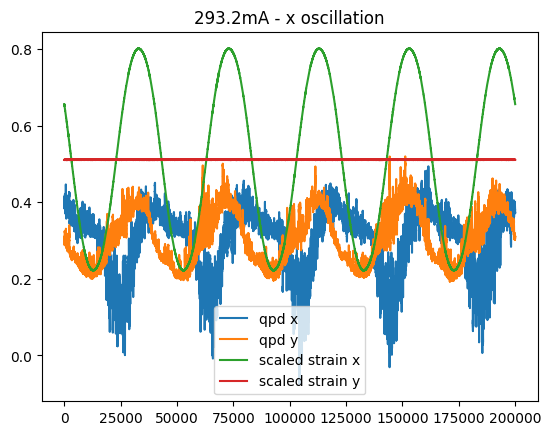

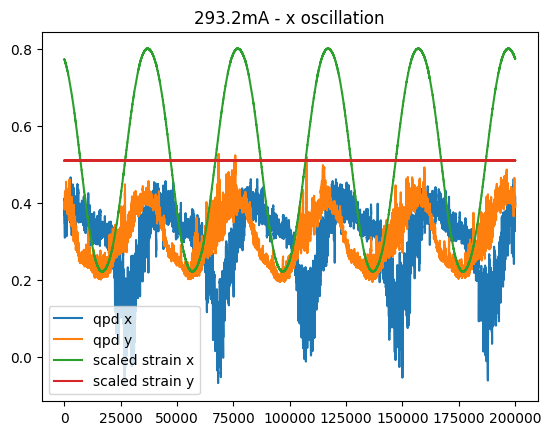

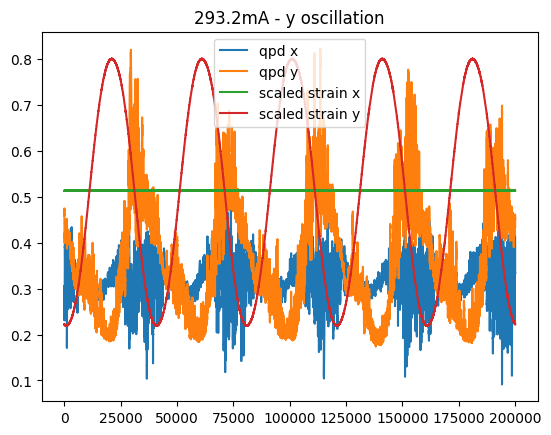

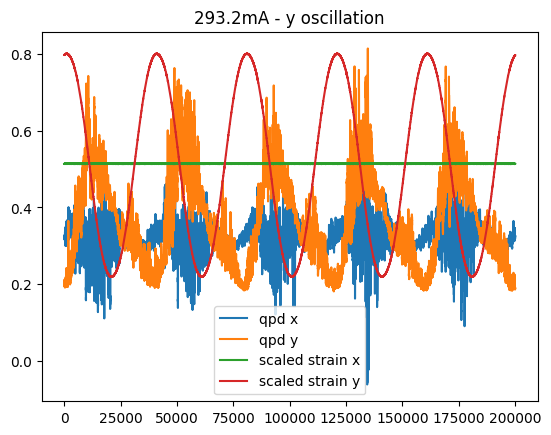

Power level 392.6mA: 4 trials
[{'axis': 'x', 'qpd_x': array([0.613937, 0.614922, 0.615579, ..., 0.48022 , 0.483834, 0.486463]), 'qpd_y': array([0.627735, 0.627735, 0.628392, ..., 0.635292, 0.632335, 0.632335]), 'strain_x': array([7.75063, 7.7503 , 7.74997, ..., 7.75556, 7.75556, 7.7549 ]), 'strain_y': array([5.10842, 5.10776, 5.10711, ..., 5.10579, 5.10481, 5.10415])}, {'axis': 'x', 'qpd_x': array([0.51636 , 0.512746, 0.510118, ..., 0.425354, 0.419769, 0.419769]), 'qpd_y': array([0.412541, 0.409255, 0.407613, ..., 0.380344, 0.381329, 0.379358]), 'strain_x': array([2.51817, 2.51817, 2.51817, ..., 2.51882, 2.51948, 2.51981]), 'strain_y': array([5.1094 , 5.10842, 5.10809, ..., 5.10481, 5.10481, 5.10415])}, {'axis': 'y', 'qpd_x': array([0.401042, 0.404656, 0.403013, ..., 0.399399, 0.397756, 0.399728]), 'qpd_y': array([0.625764, 0.627735, 0.62905 , ..., 0.68753 , 0.688516, 0.690487]), 'strain_x': array([5.13799, 5.13799, 5.13733, ..., 5.1347 , 5.13405, 5.13503]), 'strain_y': array([2.97846,

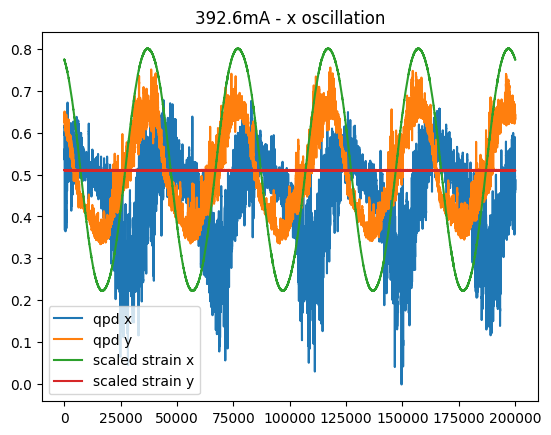

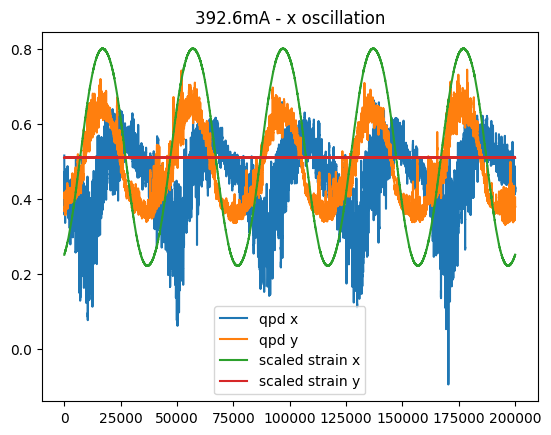

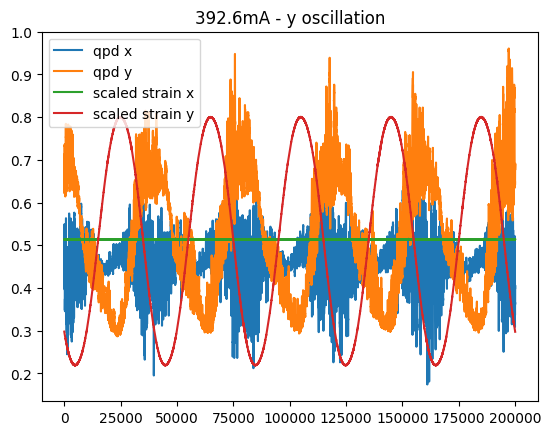

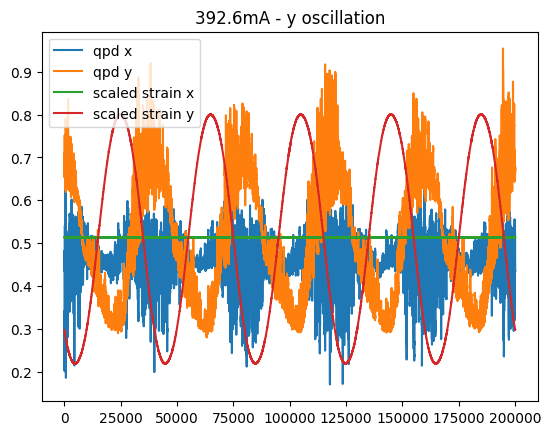

Power level 493.1mA: 4 trials
[{'axis': 'x', 'qpd_x': array([0.630364, 0.632335, 0.635949, ..., 0.603423, 0.602109, 0.59751 ]), 'qpd_y': array([0.528516, 0.526873, 0.531473, ..., 0.479892, 0.479892, 0.481535]), 'strain_x': array([2.2596 , 2.2596 , 2.26026, ..., 2.2619 , 2.26125, 2.2619 ]), 'strain_y': array([5.10481, 5.10513, 5.10612, ..., 5.10809, 5.10842, 5.10809])}, {'axis': 'x', 'qpd_x': array([0.432253, 0.435867, 0.428311, ..., 0.586339, 0.586668, 0.584039]), 'qpd_y': array([0.906996, 0.902725, 0.898782, ..., 0.837016, 0.836359, 0.839316]), 'strain_x': array([7.18289, 7.18355, 7.18387, ..., 7.1911 , 7.19143, 7.19209]), 'strain_y': array([5.10743, 5.10743, 5.10743, ..., 5.11236, 5.11302, 5.11302])}, {'axis': 'y', 'qpd_x': array([0.576483, 0.569912, 0.569255, ..., 0.553157, 0.546914, 0.548885]), 'qpd_y': array([0.995373, 0.99603 , 0.995373, ..., 0.978289, 0.982889, 0.982232]), 'strain_x': array([5.13109, 5.13043, 5.13109, ..., 5.13405, 5.13339, 5.13339]), 'strain_y': array([2.97189,

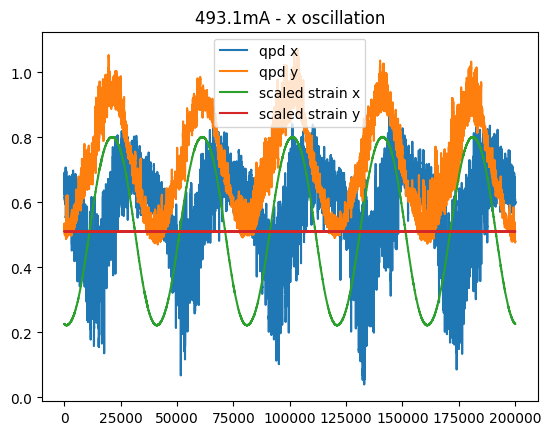

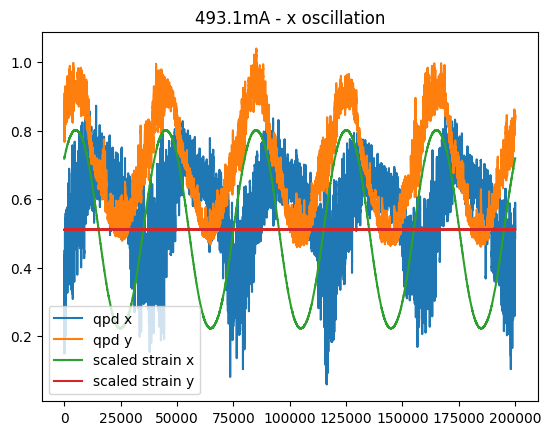

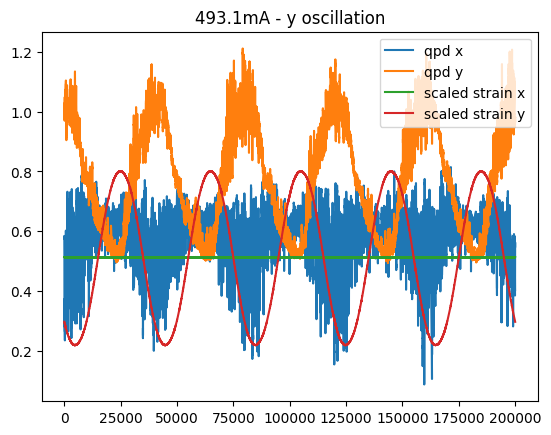

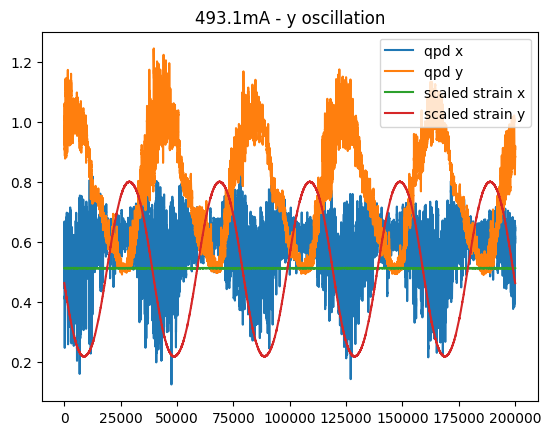

In [103]:
import glob
import os
# Import floating bead data using the same laser powers as brownian data
floating_data = []
laser_powers = [100.6, 193.2, 293.2, 392.6, 493.1]

for power in laser_powers:
    power_data = []
    power_str = str(power).split(".")
    dir_name = "_".join(power_str)
    file_start = "-".join(power_str)
    
    # Look for both x and y oscillation files
    for axis in ['x', 'y']:
        base_pattern = f'stagemodeosc{axis}a3v0_5_{file_start}mA_20k_10s_3u_10-29.txt'
        alt_pattern = f'stagemodeosc{axis}a3v0_5_{file_start}mA_20k_10s_3u_10-29_2.txt'
        matches = glob.glob(os.path.join('data', 'Real', dir_name, base_pattern))
        matches.extend(glob.glob(os.path.join('data', 'Real', dir_name, alt_pattern)))
        for file in matches:
            #Read and plot data.
            data = np.loadtxt(file)
            # Extract the 4 columns of data
            qpd_x = data[:, 0]
            qpd_y = data[:, 1]
            strain_x = data[:, 2]
            strain_y = data[:, 3]
            power_data.append({
                'axis': axis,
                'qpd_x': qpd_x,
                'qpd_y': qpd_y, 
                'strain_x': strain_x,
                'strain_y': strain_y
            })
    floating_data.append(power_data)

print(f"Loaded {len(floating_data)} power levels of floating bead data")
for i, power_data in enumerate(floating_data):
    print(f"Power level {laser_powers[i]}mA: {len(power_data)} trials")
    print(power_data)
    for j in range(0,len(power_data)):
        plt.plot(power_data[j]['qpd_x'], label='qpd x')
        plt.plot(power_data[j]['qpd_y'], label='qpd y')
        plt.plot(power_data[j]['strain_x']*0.1, label='scaled strain x')
        plt.plot(power_data[j]['strain_y']*0.1, label='scaled strain y')
        plt.title(f'{laser_powers[i]}mA - {power_data[j]["axis"]} oscillation')
        plt.legend()
        plt.show()
